In [17]:
import numpy as np
import pandas as pd
import cooler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('fivethirtyeight')

In [6]:
ep_long = pd.read_csv('/data2/josh/ep/activePairixAll.csv')

In [7]:
# Import and define chromosomes df - mm10
c = cooler.Cooler('/data2/josh/stan/merge_res200.cool')
chrs = c.chroms()[:]
chrs['name'] = chrs['name'].str.replace('chr', '')
chrs = chrs.set_index('name')
chrs.index.names = ['chrom']

In [8]:
# Import TAD list
tads = pd.read_csv('/data2/josh/tads/TAD_mm10.csv', delimiter='\t')
tads['chrom'] = tads['chrom'].str.replace('chr','')
tads['size'] = tads['end'] - tads['start']
chr_coverage = tads.groupby('chrom').sum()['size'].to_frame()
chr_coverage = chr_coverage.join(chrs)
chr_coverage['ratio'] = chr_coverage['size']/chr_coverage['length']
# chr_coverage.sort_values('ratio')

In [9]:
# define helper function ep_status
def ep_status(e_chip, p_chip):
    if ((e_chip == True) and (p_chip == True)):
        return 'EP'
    elif ((e_chip == False) and (p_chip == True)):
        return 'P'
    elif ((e_chip == True) and (p_chip == False)):
        return 'E'
    else:
        return 'N'

In [10]:
chipfiles = ['H3K27ac','H3K36me3','H3K4me1',
             'H3K4me3','H3K9ac',
             'c-Myc','CTCF','Esrrb','Klf4','Nanog','Oct4','Sox2','Suz12']

0.0
0.0
Finished H3K27ac
0.0
0.0
Finished H3K36me3
0.0
0.0
Finished H3K4me1
0.0
0.0
Finished H3K4me3
0.0
0.0
Finished H3K9ac
0.0
0.0
Finished c-Myc
0.0
0.0
Finished CTCF
0.0
0.0
Finished Esrrb
0.0
0.0
Finished Klf4
0.0
0.0
Finished Nanog
0.0
0.0
Finished Oct4
0.0
0.0
Finished Sox2
0.0
0.0
Finished Suz12


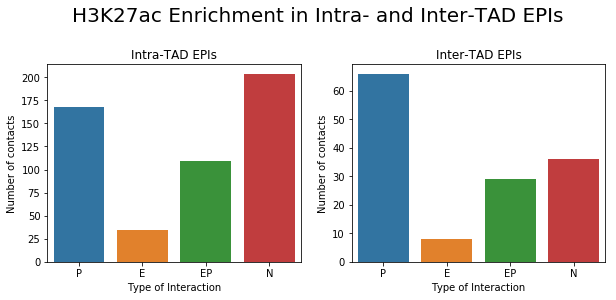

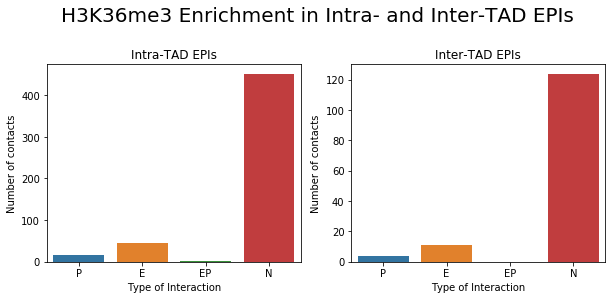

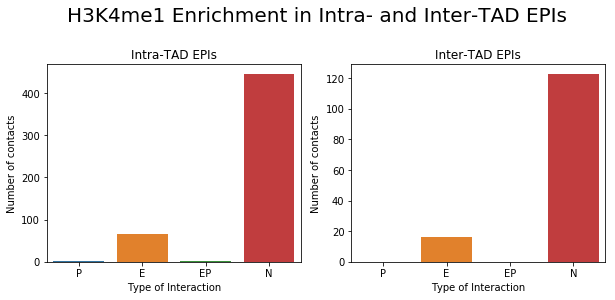

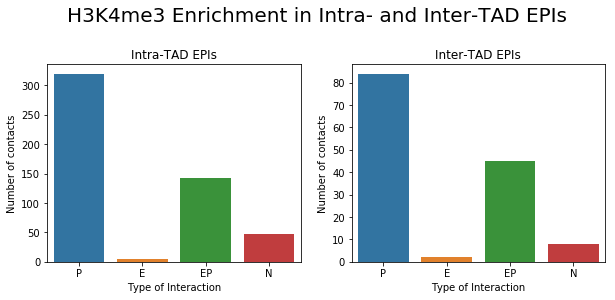

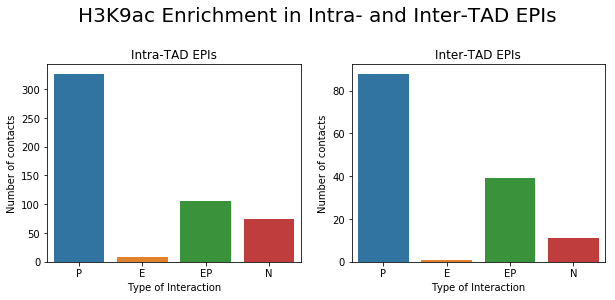

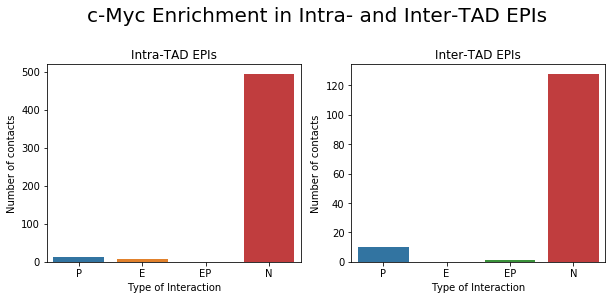

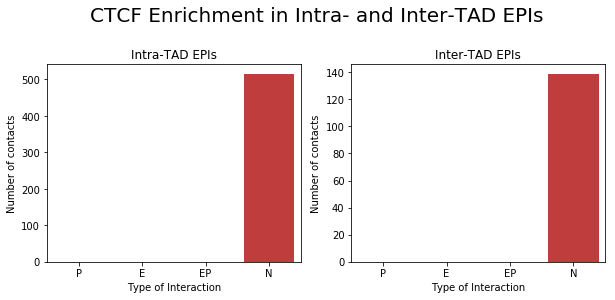

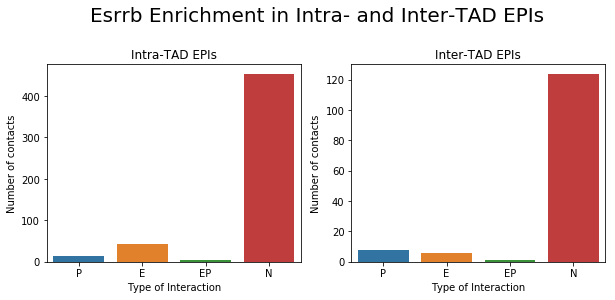

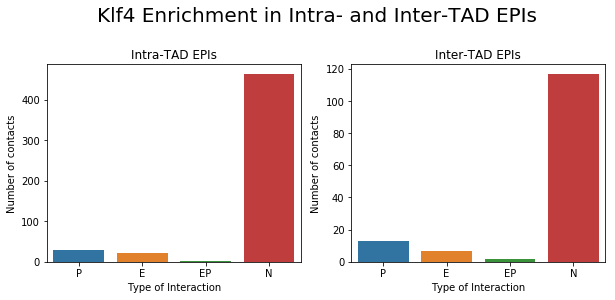

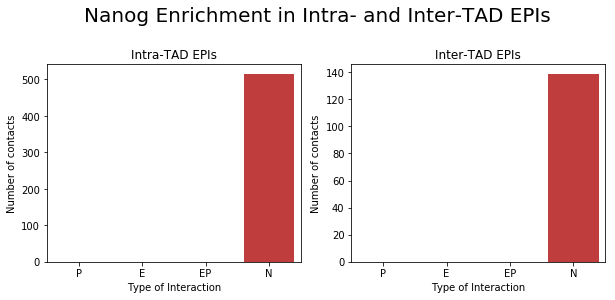

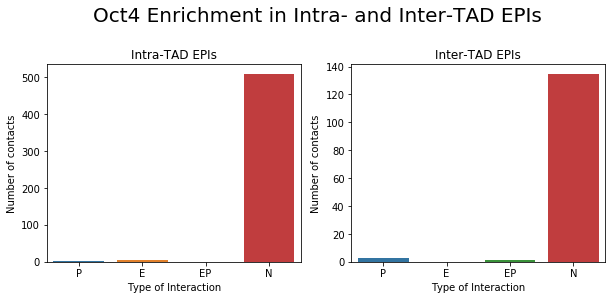

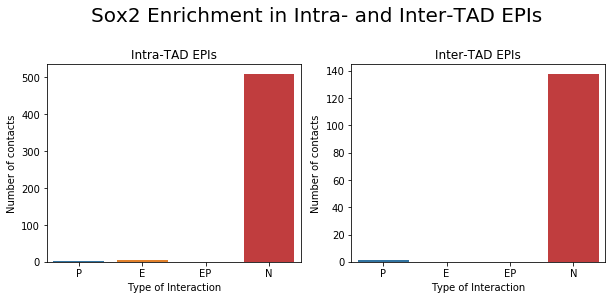

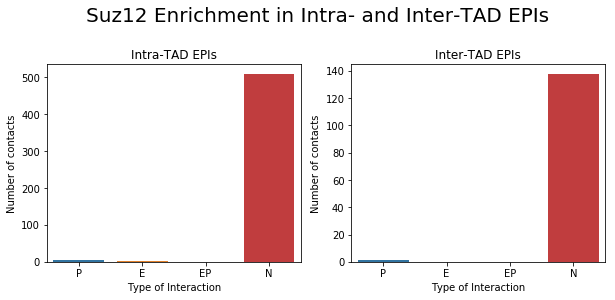

In [16]:
for chipname in chipfiles:
    # ChIP-seq to plot
    chipname_lower = chipname.lower()
    chipfile = '/data2/josh/chipseq/' + chipname + '/' + chipname_lower + '_mm10.bed'

    # Add chromatin labels
    chip = pd.read_csv(chipfile, delimiter='\t', header=None)
    chip.columns = ['chr', 'start', 'end', 'id', 'strength']

    # Label promoters as ChIP-seq overlapping or not (new column)
    promoters_chip_list = []
    counter = 0
    for idx, row in ep_long.iterrows():
        chrom = row.p_chr
        p_start = row.p_start
        p_end = row.p_end
        chip_matches = chip[(chip['chr'] == chrom) & ((chip['start'] < p_start) & (chip['end'] > p_start) |
                                                      (chip['start'] < p_end) & (chip['end'] > p_end))]
        if chip_matches.empty:
            promoters_chip_list.append(False)
        else:
            promoters_chip_list.append(True)
        if counter % 1000 == 0:
            print(float(counter)/39277)
        counter += 1

    ep_long['p_chip'] = ''
    ep_long['p_chip'] = promoters_chip_list
    
    # Label enhancers as ChIP-seq overlapping or not (new column)
    enhancers_chip_list = []
    counter = 0
    for idx, row in ep_long.iterrows():
        chrom = row.e_chr
        e_start = row.e_start
        e_end = row.e_end

        chip_matches = chip[(chip['chr'] == chrom) & ((chip['start'] < e_start) & (chip['end'] > e_start) |
                                                      (chip['start'] < e_end) & (chip['end'] > e_end))]
        if chip_matches.empty:
            enhancers_chip_list.append(False)
        else:
            enhancers_chip_list.append(True)
        if counter % 1000 == 0:
            print(float(counter)/39277)
        counter += 1

    ep_long['e_chip'] = ''
    ep_long['e_chip'] = enhancers_chip_list
    
    # Add TAD label for promoters
    promoters_tad_list = []
    for idx, row in ep_long.iterrows():
        chrom = row.p_chr[3:]
        pos = row.p_center
        tad_matches = tads[(tads['chrom'] == chrom) & (tads['start'] < pos) & (tads['end'] > pos)]
        if tad_matches.empty:
            promoters_tad_list.append(-1)
        else:
            promoters_tad_list.append(tad_matches.index[0])

    ep_long['p_tad'] = ''
    ep_long['p_tad'] = promoters_tad_list
    
    # Label EPIs as Inter or Intra
    # pix1_tad_list1 = [None] * pix1.shape[0]
    ep_long['tad_status'] = ''
    tad_list = []
    counter = 0

    for idx, row in ep_long.iterrows():
        p_chr = row['p_chr'][3:]
        e_chr = row['e_chr'][3:]
        p_start = row['p_start']
        p_end = row['p_end']
        e_start = row['e_start']
        e_end = row['e_end']

        p_tad_matches = tads[((tads['chrom'] == p_chr) & (tads['start'] < p_start) & (tads['end'] > p_end))]
        e_tad_matches = tads[((tads['chrom'] == e_chr) &(tads['start'] < e_start) & (tads['end'] > e_end))]
        if p_tad_matches.empty and e_tad_matches.empty:
            tad_list.append('TAD-less')
        elif (p_tad_matches.empty and not e_tad_matches.empty) or (e_tad_matches.empty and not p_tad_matches.empty):
            tad_list.append('Inter')
        elif p_tad_matches.index[0] == e_tad_matches.index[0]:
            tad_list.append('Intra')
        else:
            tad_list.append('Inter')

        #if counter % 1000 == 0:
        #    print(float(counter)/39277)
        #counter += 1

    ep_long['tad_status'] = tad_list
    
    # Create list for EP_status the put it into the df 
    ep_status_list = [ep_status(row['e_chip'], row['p_chip']) for idx, row in ep_long.iterrows()]
    ep_long['ep_status'] = ep_status_list
    
    intra_tad_ep = ep_long[ep_long['tad_status']=='Intra']
    inter_tad_ep = ep_long[ep_long['tad_status']=='Inter']
    
    plt.figure(figsize=[10,8])
    plt.subplot(221)

    ax1 = sns.countplot(x="ep_status", data=intra_tad_ep, order=['P','E','EP','N'])
    plt.xlabel('Type of Interaction')
    plt.ylabel('Number of contacts')
    plt.title('Intra-TAD EPIs')

    plt.subplot(222)
    ax2 = sns.countplot(x="ep_status", data=inter_tad_ep, order=['P','E','EP','N'])
    plt.xlabel('Type of Interaction')
    plt.ylabel('Number of contacts')
    plt.title('Inter-TAD EPIs')

    plt.suptitle(chipname + ' Enrichment in Intra- and Inter-TAD EPIs',size=20)

    # Save figure
    plt.savefig(chipname + '_sbs_new.png')
    
    # Save data
    ep_long.to_csv('../results/processed_' + chipname_lower + '.bed',sep='\t')
    print('Finished ' + chipname)
    